# VGG+CAPSNET

In [5]:
from __future__ import print_function
from keras import backend as K
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Updated import statement
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299

In [6]:
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    train_gen = datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/train/',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)

    val_gen = datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/val/', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test/', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

In [8]:
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [9]:
# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [10]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3, # Test number of routing with (1, 2, 3, 4) - Default = 3
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [11]:
train_batch = 32
val_batch = 1

train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool

In [13]:
for layer in base_model.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7bd51db73320> False
<keras.layers.convolutional.Conv2D object at 0x7bd51db73438> False
<keras.layers.convolutional.Conv2D object at 0x7bd51db845c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7bd51cad0dd8> False
<keras.layers.convolutional.Conv2D object at 0x7bd51cad07f0> False
<keras.layers.convolutional.Conv2D object at 0x7bd566256588> False
<keras.layers.pooling.MaxPooling2D object at 0x7bd5661f5da0> False
<keras.layers.convolutional.Conv2D object at 0x7bd5661f59e8> False
<keras.layers.convolutional.Conv2D object at 0x7bd5661aa4a8> False
<keras.layers.convolutional.Conv2D object at 0x7bd5661aae48> False
<keras.layers.pooling.MaxPooling2D object at 0x7bd5661e4c50> False
<keras.layers.convolutional.Conv2D object at 0x7bd5661e4d68> False
<keras.layers.convolutional.Conv2D object at 0x7bd56619d860> False
<keras.layers.convolutional.Conv2D object at 0x7bd566138b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7bd566151710>

In [14]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Parameters:
    gamma (float): Focusing parameter, default is 2.
    alpha (float): Balancing factor, default is 0.25.
    
    Returns:
    loss: A callable function to compute the loss for each batch.
    """
    
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate modulating factor (1 - p_t)^gamma
        modulating_factor = K.pow(1 - y_pred, gamma)

        # Calculate focal loss component
        loss = alpha * modulating_factor * cross_entropy
        
        return K.sum(loss, axis=-1)
    
    return focal_loss_fixed


In [16]:
lr=1e-4

model.compile(loss=focal_loss(gamma=2., alpha=0.25), 
              optimizer=SGD(lr=lr, momentum=0.9), 
              metrics=['accuracy'])



In [17]:
model.fit_generator(train,
                    epochs=1,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch // 15,
                    steps_per_epoch=(len(train.classes)//train_batch) // 15) 
    
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test.reset()

Epoch 1/1
10/10 [==============================] - 12s 1s/step - loss: 0.0494 - acc: 0.5000 - val_loss: 0.0398 - val_acc: 1.0000




Loss: 0.04233129179248443
Accuracy: 61.70 %






In [18]:
for i, layer in enumerate(model.layers):
    if i < 15:
        layer.trainable = False
    else:
        layer.trainable = True

In [19]:
lr=1e-4

model.compile(loss=focal_loss(gamma=2., alpha=0.25), 
              optimizer=SGD(lr=lr, momentum=0.9), 
              metrics=['accuracy'])



In [21]:
history= model.fit_generator(train,
                    epochs=10,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch ,
                    steps_per_epoch=(len(train.classes)//train_batch)) 
    
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test.reset()

Epoch 1/10
163/163 [==============================] - 158s 970ms/step - loss: 0.0381 - acc: 0.7111 - val_loss: 0.0469 - val_acc: 0.5625
Epoch 2/10
163/163 [==============================] - 158s 967ms/step - loss: 0.0353 - acc: 0.7375 - val_loss: 0.0429 - val_acc: 0.5625
Epoch 3/10
163/163 [==============================] - 158s 970ms/step - loss: 0.0362 - acc: 0.7237 - val_loss: 0.0512 - val_acc: 0.4375
Epoch 4/10
163/163 [==============================] - 158s 970ms/step - loss: 0.0331 - acc: 0.7533 - val_loss: 0.0373 - val_acc: 0.6250
Epoch 5/10
163/163 [==============================] - 159s 975ms/step - loss: 0.0326 - acc: 0.7552 - val_loss: 0.0565 - val_acc: 0.3750
Epoch 6/10
163/163 [==============================] - 158s 971ms/step - loss: 0.0313 - acc: 0.7607 - val_loss: 0.0384 - val_acc: 0.6250
Epoch 7/10
163/163 [==============================] - 159s 973ms/step - loss: 0.0291 - acc: 0.7803 - val_loss: 0.0422 - val_acc: 0.5625
Epoch 8/10
163/163 [============================

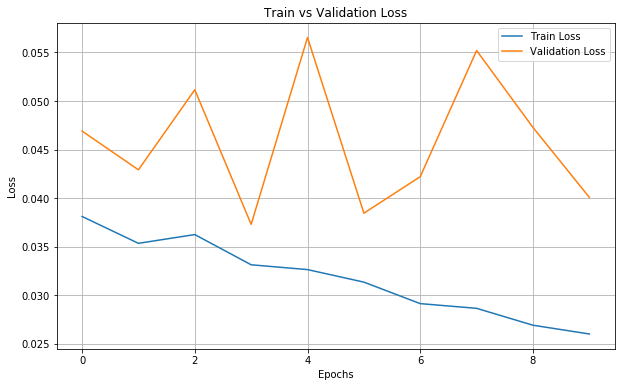

In [22]:
# Plotting the loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
output = Conv2D(256, kernel_size=(9, 9), strides=(1, 1), activation='relu')(base_model.get_layer(name='block5_pool').output)

x = Reshape((-1, 256))(output)
capsule = Capsule(2, 16, 4, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [24]:
lr=1e-4

checkpoint = ModelCheckpoint("weights.keras",
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)

callback_list = [checkpoint, early]
print("test")

test


In [32]:
epochs=10

model.compile(loss=margin_loss, optimizer=SGD(lr=lr, momentum=0.9), metrics=['accuracy'])

history= model.fit_generator(train,
                    epochs=epochs,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=len(train.classes)//train_batch * 2,
                    callbacks=callback_list)
    
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

Epoch 1/10
326/326 [==============================] - 322s 986ms/step - loss: 0.0459 - acc: 0.9337 - val_loss: 0.0641 - val_acc: 0.9375

Epoch 00001: val_loss improved from inf to 0.06405, saving model to weights.keras
Epoch 2/10
326/326 [==============================] - 314s 962ms/step - loss: 0.0229 - acc: 0.9675 - val_loss: 0.2560 - val_acc: 0.6875

Epoch 00002: val_loss did not improve from 0.06405
Epoch 3/10
326/326 [==============================] - 319s 977ms/step - loss: 0.0205 - acc: 0.9698 - val_loss: 0.1481 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.06405
Epoch 4/10
326/326 [==============================] - 316s 971ms/step - loss: 0.0164 - acc: 0.9772 - val_loss: 0.0569 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.06405 to 0.05686, saving model to weights.keras
Epoch 5/10
326/326 [==============================] - 317s 971ms/step - loss: 0.0179 - acc: 0.9751 - val_loss: 0.0921 - val_acc: 0.8750

Epoch 00005: val_loss did not improve from 0.

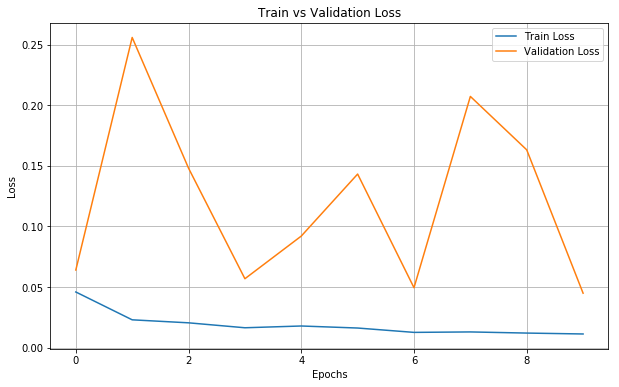

In [33]:
# Plotting the loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


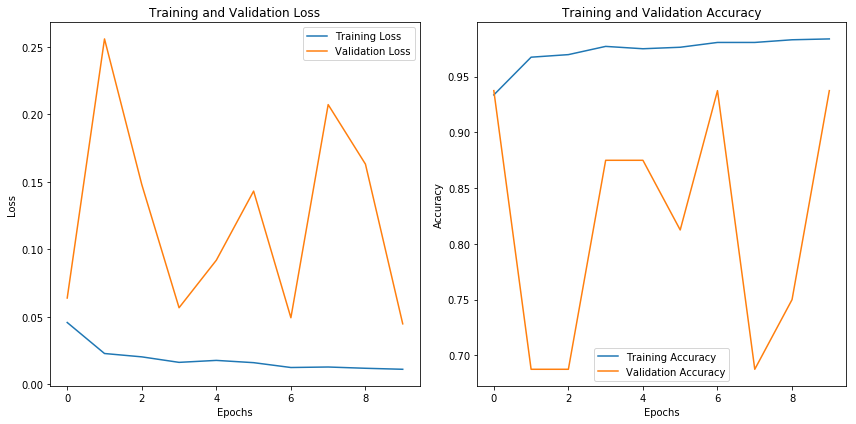

In [34]:
# Plot the training history (loss and accuracy)
def plot_history(history):
    # Training and Validation Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_history(history)


In [44]:
from sklearn.metrics import classification_report

# Predict on the test set
test_predictions = model.predict_generator(test, len(test))

# Convert predictions to class labels (assuming one-hot encoding)
test_labels = test.classes

# If test labels are in one-hot format, you might need to convert predictions as well
test_predictions = test_predictions.argmax(axis=-1)

# Print the classification report (precision, recall, F1-score)
print(classification_report(test_labels, test_predictions))


              precision    recall  f1-score   support

           0       0.38      0.24      0.29       234
           1       0.63      0.77      0.69       390

    accuracy                           0.57       624
   macro avg       0.51      0.50      0.49       624
weighted avg       0.54      0.57      0.54       624



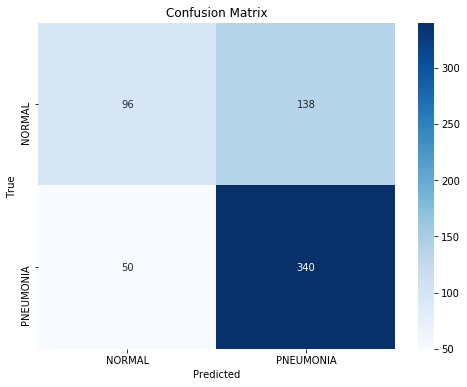

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


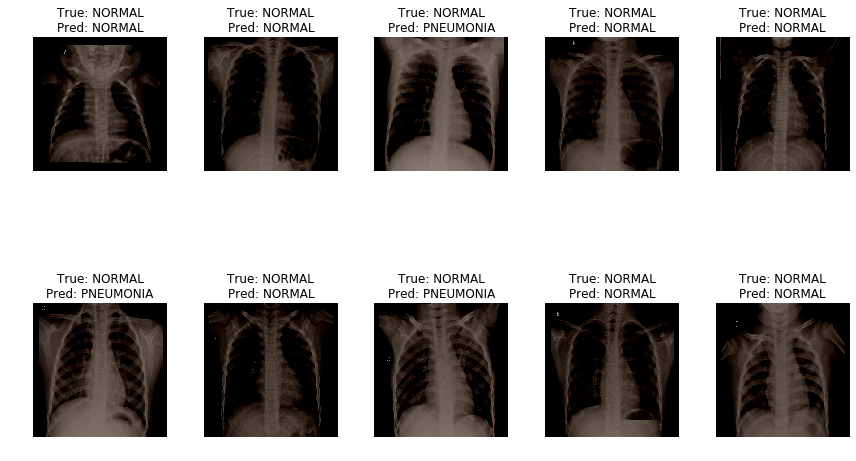

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Number of predictions to display
num_predictions = 10

# Generate predictions for the test set (get a batch)
# Assuming 'test' is a generator, we get a batch of images and their true labels
test_batch = next(iter(test))  # Get a batch of data from the test generator
images, true_labels = test_batch[0], test_batch[1]

# Make predictions on this batch
predictions = model.predict(images)

# Convert predictions to class labels (if using one-hot encoding)
predicted_labels = np.argmax(predictions, axis=-1)

# Get the class labels (assuming test is a generator and has .class_indices)
class_labels = list(test.class_indices.keys())

# Plot the images with their true and predicted labels
plt.figure(figsize=(12, 8))

for i in range(num_predictions):
    plt.subplot(2, num_predictions // 2, i + 1)
    plt.imshow(images[i])
    true_label = class_labels[np.argmax(true_labels[i])]  # Get the true label
    predicted_label = class_labels[predicted_labels[i]]   # Get the predicted label
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [38]:
"""#import joblib
import pandas as pd

# Load the model from the dataset path
#model_1 = joblib.load('/kaggle/input/your-dataset-name/model_1.pkl')

# Load predictions
predictions_model_1 = pd.read_csv('/kaggle/input/y-pred/y_pred.csv')
"""

"#import joblib\nimport pandas as pd\n\n# Load the model from the dataset path\n#model_1 = joblib.load('/kaggle/input/your-dataset-name/model_1.pkl')\n\n# Load predictions\npredictions_model_1 = pd.read_csv('/kaggle/input/y-pred/y_pred.csv')\n"

In [47]:
y_pred_model_1 = pd.read_csv('/kaggle/input/y-pred/y_pred.csv')


In [52]:
len(test_predictions)

624

In [54]:
# Load the predictions from the first model
#y_pred_model_1 = pd.read_csv('/kaggle/input/y-pred/y_pred.csv')['Predicted_Labels'].values

# Ensure y_pred_model_1 and test_predictions have the same length
y_pred_model_1 = y_pred_model_1[:len(test_predictions)]

assert len(y_pred_model_1) == len(test_predictions), "Mismatch in the length of predictions!"
# Predict on the test set for the second model (already provided in your code)
test_predictions = model.predict_generator(test, len(test))
test_predictions = test_predictions.argmax(axis=-1)

In [53]:
len(y_pred_model_1)

624

In [40]:
"""import pandas as pd

# Convert y_pred to a DataFrame
y_pred_df = pd.DataFrame(test_predictions, columns=['Predicted_Labels'])

# Save the DataFrame to a CSV file
y_pred_df.to_csv('/kaggle/working/y_pred_cap.csv', index=False)"""

"import pandas as pd\n\n# Convert y_pred to a DataFrame\ny_pred_df = pd.DataFrame(test_predictions, columns=['Predicted_Labels'])\n\n# Save the DataFrame to a CSV file\ny_pred_df.to_csv('/kaggle/working/y_pred_cap.csv', index=False)"

In [64]:
print(f"Shape of y_pred_model_1: {y_pred_model_1.shape}")
print(f"Shape of test_predictions: {test_predictions.shape}")



Shape of y_pred_model_1: (624,)
Shape of test_predictions: (624,)


In [131]:
import numpy as np
import pandas as pd


weight_model_1 = 0.8  # Weight for Model 1
weight_model_2 = 0.5 # Weight for Model 2


ensemble_predictions = (weight_model_1 * y_pred_model_1) + (weight_model_2 * test_predictions)

final_predictions = (ensemble_predictions >= 0.5).astype(int)

print(classification_report(test_predictions, final_predictions))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       492
           1       0.96      0.97      0.97       132

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.99      0.98      0.98       624
